In [36]:
import bilby

sly = bilby.gw.eos.TabularEOS("SLY4")
sly_family = bilby.gw.eos.EOSFamily(sly)

In [37]:
sly_family.plot(rep="m-r")

KeyError: 'm'

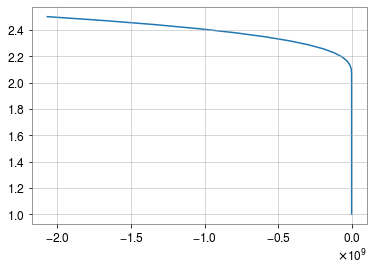

In [41]:
import numpy as np
import matplotlib.pyplot as plt

masses = np.linspace(1, 2.5, 50)
radii = []
for mass in masses:
    radii.append(sly_family.radius_from_mass(mass)*1e-3)

plt.plot(radii, masses)

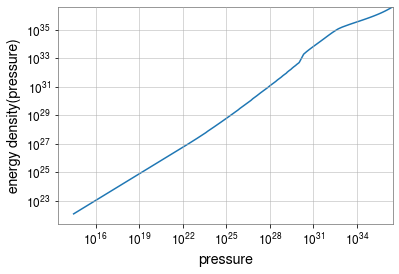

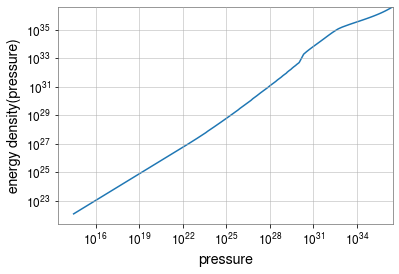

In [38]:
sly.plot("energy_density-pressure")

In [42]:
radii = np.linspace(1, 2.5, 50)

array([1.        , 1.03061224, 1.06122449, 1.09183673,
       1.12244898, 1.15306122, 1.18367347, 1.21428571,
       1.24489796, 1.2755102 , 1.30612245, 1.33673469,
       1.36734694, 1.39795918, 1.42857143, 1.45918367,
       1.48979592, 1.52040816, 1.55102041, 1.58163265,
       1.6122449 , 1.64285714, 1.67346939, 1.70408163,
       1.73469388, 1.76530612, 1.79591837, 1.82653061,
       1.85714286, 1.8877551 , 1.91836735, 1.94897959,
       1.97959184, 2.01020408, 2.04081633, 2.07142857,
       2.10204082, 2.13265306, 2.16326531, 2.19387755,
       2.2244898 , 2.25510204, 2.28571429, 2.31632653,
       2.34693878, 2.37755102, 2.40816327, 2.43877551,
       2.46938776, 2.5       ])

array([14.5312991 , 13.80456699, 13.32836841, 13.00144761,
       12.76604786, 12.59304019, 12.46211717, 12.36148133,
       12.28328122, 12.22177598, 12.17290631, 12.13336496,
       12.10106546, 12.0742883 , 12.05253528, 12.03351157,
       12.01703837, 12.00236995, 11.98897513, 11.97666117,
       11.96444636, 11.95265513, 11.94046842, 11.92799385,
       11.9149574 , 11.90108961, 11.88620895, 11.87014362,
       11.85270143, 11.83368825, 11.81312971, 11.79050409,
       11.7658614 , 11.73901597, 11.70956996, 11.67728617,
       11.64197197, 11.60315536, 11.56045549, 11.51338134,
       11.46110718, 11.40294011, 11.33790276, 11.26435473,
       11.18025283, 11.08219027, 10.96510646, 10.81841525,
       10.6178069 , 10.21038926])

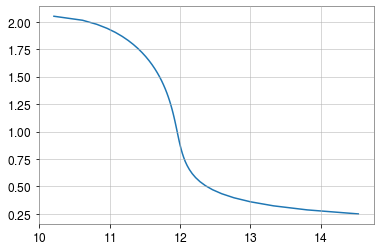

In [66]:
masses = np.linspace(0.25, 2.05, 50)
radii = sly_family.radius_from_mass(masses)*1e-3

fig, ax = plt.subplots()
ax.plot(radii, masses)

radii

In [ ]:
#!/usr/bin/env python
"""
Tutorial to demonstrate running parameter estimation on a binary neutron star
system taking into account tidal deformabilities.

This example estimates the masses using a uniform prior in both component masses
and also estimates the tidal deformabilities using a uniform prior in both
tidal deformabilities
"""

from __future__ import division, print_function

import numpy as np

import bilby
from bilby.gw.eos import TabularEOS, EOSFamily

# Specify the output directory and the name of the simulation.
outdir = 'outdir'
label = 'bns_eos_example'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

# We are going to inject a binary neutron star waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# aligned spins of both black holes (chi_1, chi_2), etc.

# We're also going to 'inject' the MPA1 equation of state.
# This is done by injecting masses for the two neutron-stars,
# assuming a specific equation of state, and calculating
# corresponding tidal deformability parameters from the EoS and
# masses.
mpa1_eos = TabularEOS('MPA1')
mpa1_fam = EOSFamily(mpa1_eos)

mass_1 = 1.5
mass_2 = 1.3
lambda_1 = mpa1_fam.lambda_from_mass(mass_1)
lambda_2 = mpa1_fam.lambda_from_mass(mass_2)


injection_parameters = dict(
    mass_1=mass_1, mass_2=mass_2, chi_1=0.02, chi_2=0.02, luminosity_distance=50.,
    theta_jn=0.4, psi=2.659, phase=1.3, geocent_time=1126259642.413,
    ra=1.375, dec=-1.2108, lambda_1=lambda_1, lambda_2=lambda_2)

# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 32
sampling_frequency = 2 * 1024
start_time = injection_parameters['geocent_time'] + 2 - duration

# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
# Note that the EoS sampling is agnostic to waveform model as long as the approximant
# can include tides.
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2_NRTidal',
                          reference_frequency=50., minimum_frequency=40.0)

# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments)

# Set up interferometers.  In this case we'll use three interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1), and Virgo (V1)).
# These default to their design sensitivity and start at 40 Hz.
interferometers = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])
for interferometer in interferometers:
    interferometer.minimum_frequency = 40
interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=start_time)
interferometers.inject_signal(parameters=injection_parameters,
                              waveform_generator=waveform_generator)

# We're going to sample in chirp_mass, symmetric_mass_ratio, and
# specific EoS model parameters. We're using a 4-parameter
# spectrally-decomposed EoS parameterization from Lindblom (2010).
# BNS have aligned spins by default, if you want to allow precessing spins
# pass aligned_spin=False to the BNSPriorDict
priors = bilby.gw.prior.BNSPriorDict()
for key in ['psi', 'geocent_time', 'ra', 'dec', 'chi_1', 'chi_2',
            'theta_jn', 'luminosity_distance', 'phase']:
    priors[key] = injection_parameters[key]
priors.pop('mass_1')
priors.pop('mass_2')
priors.pop('lambda_1')
priors.pop('lambda_2')
priors['chirp_mass'] = bilby.core.prior.Gaussian(
    1.215, 0.1, name='chirp_mass', unit='$M_{\\odot}$')
priors['symmetric_mass_ratio'] = bilby.core.prior.Uniform(
    0.1, 0.25, name='symmetric_mass_ratio')
priors['eos_spectral_gamma_0'] = bilby.core.prior.Uniform(0.2, 2.0, name='gamma0', latex_label='$\\gamma_0')
priors['eos_spectral_gamma_1'] = bilby.core.prior.Uniform(-1.6, 1.7, name='gamma1', latex_label='$\\gamma_1')
priors['eos_spectral_gamma_2'] = bilby.core.prior.Uniform(-0.6, 0.6, name='gamma2', latex_label='$\\gamma_2')
priors['eos_spectral_gamma_3'] = bilby.core.prior.Uniform(-0.02, 0.02, name='gamma3', latex_label='$\\gamma_3')

# The eos_check prior imposes several hard physical constraints on samples like
# enforcing causality and monotinicity of the EoSs. In almost ever conceivable
# sampling scenario, this should be enabled.
priors['eos_check'] = bilby.gw.prior.EOSCheck()

# Initialise the likelihood by passing in the interferometer data (IFOs)
# and the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=interferometers, waveform_generator=waveform_generator,
    time_marginalization=False, phase_marginalization=False,
    distance_marginalization=False, priors=priors)

# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=1000,
    injection_parameters=injection_parameters, outdir=outdir, label=label,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
    resume=True)

result.plot_corner()
